# 重回帰分析（実践）

----

## データの読み込み等準備

In [1]:
import pandas as pd

In [2]:
from mpl_toolkits.mplot3d import Axes3D # 3Dplot
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('winequality-red.csv', sep=';')

x = df[['density', 'volatile acidity']]
y = df[['alcohol']]
x1 = df[['density']]
x2 = df[['volatile acidity']]

## scikit-learnを使った重回帰分析

### 正規化なし

In [4]:
from sklearn.linear_model import LinearRegression
import numpy as np

In [5]:
model_lr = LinearRegression()
model_lr.fit(x,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

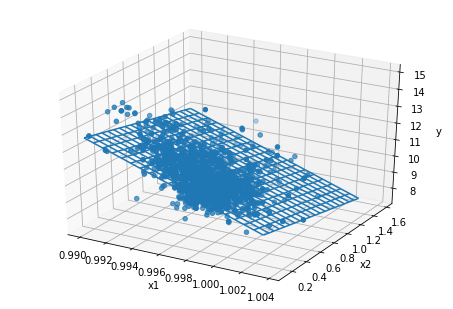

[[-277.78274856   -1.13941954]]
[287.90342428]
0.28283042699952976


In [6]:
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter3D(x1, x2, y)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("y")

mesh_x1 = np.arange(x1.min()[0], x1.max()[0], (x1.max()[0] - x1.min()[0]) / 20)
mesh_x2 = np.arange(x2.min()[0], x2.max()[0], (x2.max()[0] - x2.min()[0]) / 20)

mesh_x1, mesh_x2 = np.meshgrid(mesh_x1, mesh_x2)
mesh_y = model_lr.coef_[0][0] * mesh_x1 + model_lr.coef_[0][1] * mesh_x2 + model_lr.intercept_[0]

ax.plot_wireframe(mesh_x1, mesh_x2, mesh_y)
plt.show()

print(model_lr.coef_) # 偏回帰係数
print(model_lr.intercept_) # 切片
print(model_lr.score(x, y)) # 決定係数

`np.arange`は連番や等差数列を生成する関数。  
第一引数は初項、第二引数は末項、第三引数は等差となる。  
第二引数以外は省略可能。

`np.meshgrid`は各座標の要素列から格子座標を作成する関数。  
例えばx座標とy座標の要素が入った配列を指定すると、各軸のグリッドの要素を返す。

`model_lr.coef_`は回帰変数のアトリビュートで、`model_lr.intercept_`は切片のアトリビュート。  
アトリビュートの説明は以下URL参照：https://www.lifewithpython.com/2018/09/python-attribute-access-internal-flow.html

### 正規化（標準化）

まずは変数の正規化

In [7]:
from sklearn import preprocessing

sscaler = preprocessing.StandardScaler()

'''
sscaler.fit(x)
sscaler.fit(y)

xss = sscaler.transform(x)
yss = sscaler.transform(y)
'''
xss = sscaler.fit_transform(x)
yss = sscaler.fit_transform(y)

print(xss)
print(yss)

[[ 0.55827446  0.96187667]
 [ 0.02826077  1.96744245]
 [ 0.13426351  1.29706527]
 ...
 [-0.53355375 -0.09955388]
 [-0.67665745  0.65462046]
 [-0.66605717 -1.21684919]]
[[-0.96024611]
 [-0.58477711]
 [-0.58477711]
 ...
 [ 0.54162988]
 [-0.20930812]
 [ 0.54162988]]


重回帰分析（線形回帰）

In [8]:
# インスタンス化して
model_lr_std = LinearRegression()
# 予測モデルの作成
model_lr_std.fit(xss, yss)

print(model_lr_std.coef_)
print(model_lr_std.intercept_)
print(model_lr_std.score(xss, yss))

[[-0.49196281 -0.19145194]]
[1.1769986e-14]
0.28283042699952887


次に標準化偏回帰係数（xss）を使ってyを予測する  
まずは正規化前のモデルを使って確認

In [9]:
print(model_lr.predict(x))

[[ 9.93420409]
 [10.00689132]
 [10.08806511]
 ...
 [10.72292626]
 [10.64410597]
 [11.02025586]]


`model_lr.predict(x)`でモデル`model_lr`を使った予測を行う。  
今回はこれが本来求めたい値となる。  
次に正規化したモデルを使って予測を行う。

In [10]:
print(sscaler.inverse_transform(model_lr_std.predict(xss)))

[[ 9.93420409]
 [10.00689132]
 [10.08806511]
 ...
 [10.72292626]
 [10.64410597]
 [11.02025586]]


正規化後のモデルで予測した場合、本来求めたい値とは大きく異なった値が予測される。  
そこで`inverse_transform`を使って正規化前のモデルに戻す必要がある。

次にNumpyで予測計算を行う。

In [11]:
print(model_lr_std.predict(xss) * np.std(y.values) + np.mean(y.values))

[[ 9.93420409]
 [10.00689132]
 [10.08806511]
 ...
 [10.72292626]
 [10.64410597]
 [11.02025586]]


Numpyの場合は逆変換のメソッドがない（？）ため、正規化するときと逆の計算を行って手動で逆変換を行う必要がある。  
また、`x.values`でpandasのDataFrameであるxからNumpy配列への変換を行っている。

実際は、標準化偏回帰係数と偏回帰係数は正規化しなくても求めることができる。  
（参考：https://www.weblio.jp/content/標準化偏回帰係数）

Numpyで偏回帰係数から標準化偏回帰係数の計算を行う

In [12]:
b = model_lr.coef_ * ((x.apply(lambda x: x.var() / y.values.var()))**(0.5)).values

print(b)

[[-0.49211671 -0.19151183]]


正規化により求めた標準偏回帰係数と計算により求めた標準化偏回帰係数を比較した結果は以下の通り。  
結果はほぼ一致する。  
このように簡単に変換できるので、正規化しないで重回帰分析を行い、偏回帰係数を求める。その後必要に応じて標準化偏回帰係数を求めた方が計算上は楽になる。

In [13]:
print('model_lr_std.coef_ : ' ,model_lr_std.coef_)
print('b : ' ,b)

('model_lr_std.coef_ : ', array([[-0.49196281, -0.19145194]]))
('b : ', array([[-0.49211671, -0.19151183]]))


### 正規化あり（min-maxスケーリング）

次にmin-maxスケーリングをした値で重回帰分析を行う  
まず値をmin-maxスケーリングにより正規化

In [14]:
mscaler = preprocessing.MinMaxScaler()

mscaler.fit(x)
xms = mscaler.transform(x)
mscaler.fit(y)
yms = mscaler.transform(y)

In [15]:
model_lr_norm = LinearRegression()
model_lr_norm.fit(xms, yms)

print(model_lr_norm.coef_)
print(model_lr_norm.intercept_)
print(model_lr_norm.score(xms, yms))

[[-0.5820617  -0.25593116]]
[0.66805047]
0.28283042699952876


次にyの値を予測する  
前回同様に逆変換が必要となる

In [16]:
print(mscaler.inverse_transform(model_lr_norm.predict(xms)))

[[ 9.93420409]
 [10.00689132]
 [10.08806511]
 ...
 [10.72292626]
 [10.64410597]
 [11.02025586]]


Numpyでも予測してみる

In [17]:
pre_np = model_lr_norm.predict(xms) * (np.max(y.values) - np.min(y.values)) + np.min(y.values)

print(pre_np)

[[ 9.93420409]
 [10.00689132]
 [10.08806511]
 ...
 [10.72292626]
 [10.64410597]
 [11.02025586]]


### Numpyを使った重回帰分析

ここではscikit-learnを使わず、Numpyで重回帰分析を行う。  
単回帰分析の場合は共分散と分散から計算ができたが、重回帰分析の場合は、偏回帰係数を行列演算で計算する。  
（参考：https://tutorials.chainer.org/ja/07_Regression_Analysis.html）

まずは、scikit-learnを使った重回帰分析での偏回帰係数の値を確認する。

In [18]:
model_lr_std.fit(xss, yss)

print(model_lr_std.coef_)

[[-0.49196281 -0.19145194]]


Numpyで行列演算を行う。  
逆行列を求める`linalg`モジュールを`LA`としてimportする

In [19]:
from numpy import linalg as LA

ここでの＠は行列の積（今回はnp.dotを使用）  
また、`LA.inv`は逆行列を求めるメソッド

In [20]:
# LA.inv(xss.T @ xss) @ xss.T @ yss
# PythonかNumpyのバージョンの問題で@演算子が使えなかったから
# np.dotの乱用

cal0 = LA.inv(np.dot(xss.T, xss))
cal1 = np.dot(cal0, xss.T)
cal2 = np.dot(cal1, yss)

print(cal2)

[[-0.49196281]
 [-0.19145194]]


Numpyで逆行列が計算できないとき、`LinAlgError: Singular matrix`というエラーが発生する。  
無理やり計算したいときには`np.linalg.pinv`を用いると可能になる。

### 決定係数

決定係数は単回帰分析のときと同様に、全変動（S_all）、回帰変動（S_reg）、残差変動（S_res）から計算できる。  
しかし、入力変数が多くなるほど1に近づくので、入力変数が複数あるときは入力変数の個数（p）で補正する「自由度調整済み決定係数」R_fを用いる。  
（参考1：https://bellcurve.jp/statistics/course/9706.html）  
（参考2：https://ja.wikipedia.org/wiki/%E6%B1%BA%E5%AE%9A%E4%BF%82%E6%95%B0）

S_allの計算

In [21]:
s_all = ((yss - yss.mean())**2).sum()
print(s_all)

1599.0


S_regの計算

In [23]:
s_reg = ((model_lr_std.predict(xss) - yss.mean())**2).sum()
print(s_reg)

452.24585277224725


S_resの計算

In [25]:
s_res = ((yss - model_lr_std.predict(xss))**2).sum()
print(s_res)

1146.7541472277533


S_all = S_reg + S_resとなることの確認

In [26]:
print('Sall: %.3f' %s_all)
print('Sreg + Sres: %.3f' %(s_reg + s_res))

Sall: 1599.000
Sreg + Sres: 1599.000


次にR_fの計算を行う。  
今回の入力変数の個数は2個なのでP=2となる。

In [27]:
r_f = 1 - (s_res / (yss.size - 2- 1)) / (s_all / (yss.size - 1))
print(r_f)

0.28193171826143293


単回帰分析のときと同様に補正なしで決定係数を求めると以下のようになる。

In [28]:
print(s_reg / s_all) 

0.28283042699952926


### 相関行列

入力変数の相関関係を確認するために、相関行列を求める。  
（参考1：https://algorithm.joho.info/programming/python/scikit-learn-datasets-load_diabetes/）  
（参考2：http://zellij.hatenablog.com/entry/20130510/p1）

scikit-learnでは以下のようにして相関行列を求める。

In [29]:
import seaborn as sns

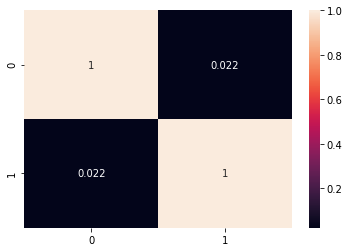

In [30]:
# 相関行列の計算
corr = np.corrcoef(xss.T)

# 相関行列をヒートマップで可視化
sns.heatmap(corr, annot=True)
plt.show()

ここでの`np.corrcoef()`は相関係数を求める関数。  
また、`sns.heatmap()`で`annot=True`と指定することで、セルに値を出力することができる。

Numpyでは入力変数の転置行列と入力変数の行列の積を計算して、対角行列が1になるようにスケーリングすることにより求めることができる。

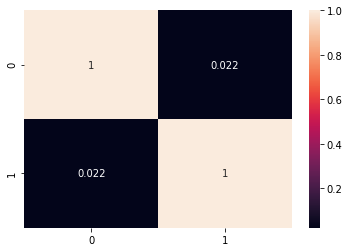

In [31]:
corr_np = np.dot(xss.T, xss) / yss.size

sns.heatmap(corr_np, annot=True)
plt.show()